In [18]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
import tensorflow as tf

In [131]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM
from tensorflow.keras.layers import Add

# Read Caption's File

In [3]:
# Reading the Description File

with open(r"./Flickr_Data\Flickr_Data\Flickr_TextData\Flickr8k.token.txt") as filepath:
    captions = filepath.read()
    filepath.close()

In [4]:
captions = captions.split("\n")[:-1]

In [5]:
len(captions)

40460

In [7]:
# creating a description directory where key is img_name and value is list of captions corresponding to that image_file.

descriptions = {}

for el in captions:
    i_to_c = el.split("\t")
    img_name = i_to_c[0].split(".")[0]
    cap = i_to_c[1]
    
    if descriptions.get(img_name) == None:
        descriptions[img_name] = []
        
    descriptions[img_name].append(cap)

In [10]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

<function matplotlib.pyplot.show(*args, **kw)>

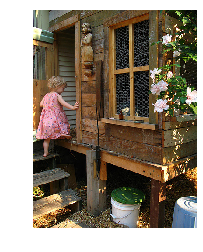

In [16]:
IMG_Path = "Flickr_Data/Flickr_Data/Images/"

img = cv2.imread(IMG_Path+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show


# Data Cleaning

In [34]:
""" 1. lower each word
    2. remove puntuations"""

def clean_text(sample):
    sample = sample.lower()
    
    sample = re.sub("[^a-z]+"," ",sample)
    
    sample = sample.split()
    
    sample = [s for s in sample if len(s)>1]
    
    sample = " ".join(sample)
    
    return sample

In [35]:
clean_text("My noghsujf si am m cricket101 &8 mphi*&86%%&??,BY6fajdn 213 q rqu243 boy  32 ewr wO>>J DHD 34  asfb HHGY Gvg HgB   231 123")

'my noghsujf si am cricket mphi by fajdn rqu boy ewr wo dhd asfb hhgy gvg hgb'

In [36]:
# modify all the captions i.e. - cleaned captions

for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc_list[i] = clean_text(desc_list[i])

In [37]:
# clean descriptions

descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [38]:
#writing clean description to .txt file

f = open("descriptions.txt", "w")
f.write(str(descriptions))
f.close()

In [42]:
# reading descriptions file
f = open("descriptions.txt", 'r')
descriptions = f.read()
f.close()

json_acceptable_string = descriptions.replace("'", "\"")
descriptions = json.loads(json_acceptable_string)

# Vocabulary


In [43]:
vocabulary = set()

for key in descriptions.keys():
    [vocabulary.update(i.split()) for i in descriptions[key]]
    
print("Voacbulary Size: %d" % len(vocabulary))

Voacbulary Size: 8424


In [44]:
#All words in description dictionary

all_vocab = []

for key in descriptions.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]
    
print("Vocabulary Size: %d" %len(all_vocab))
print(all_vocab[:15])

Vocabulary Size: 373837
['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl']


In [45]:
#  count the frequency of each word, sort them and discard the words having frequency lesser than threshold value

import collections


counter= collections.Counter(all_vocab)

dic_ = dict(counter)

threshelod_value = 10

sorted_dic = sorted(dic_.items(), reverse=True, key = lambda x: x[1])
sorted_dic = [x for x in sorted_dic if x[1]>threshelod_value]
all_vocab = [x[0] for x in sorted_dic]

In [46]:
len(all_vocab)

1845

# Loading Training Testing Data

In [47]:
# train_images file

f = open(r"Flickr_Data\Flickr_Data\Flickr_TextData\Flickr_8k.trainImages.txt")
train = f.read()
f.close()

In [48]:
train = [e.split(".")[0] for e in train.split("\n")[:-1]]

In [49]:
#test_images file

f = open(r"Flickr_Data\Flickr_Data\Flickr_TextData\Flickr_8k.testImages.txt")
test = f.read()
f.close()

In [50]:
test  = [e.split(".")[0] for e in test.split("\n")[:-1]]

In [66]:
# create train_descriptions dictionary, which will be similar to earlier one, but have train samples
# add startseq + endseq

train_descriptions = {}

for t in train:
    train_descriptions[t] = []
    for cap in descriptions[t]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[t].append(cap_to_append)

In [69]:
train_descriptions['3385593926_d3e9c21170']

['startseq the dogs are in the snow in front of fence endseq',
 'startseq the dogs play on the snow endseq',
 'startseq two brown dogs playfully fight in the snow endseq',
 'startseq two brown dogs wrestle in the snow endseq',
 'startseq two dogs playing in the snow endseq']

# Data Preprocessing - Images

In [71]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))

102858752/102853048 [==============================] - 20s 0us/step


In [74]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [92]:
# Create a new model, by removing the last layer (output of 1000 classes) from the resnet50

model_new = Model(model.input, model.layers[-2].output)

In [101]:
images = "./Flickr_Data/Flickr_Data/Images/"
len(images)

33

In [94]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [95]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [111]:
start = time()

encoding_train = {}

for ix, img in enumerate(train):
    
    img = "./Flickr_Data/Flickr_Data/Images/{}.jpg".format(train[ix])
    encoding_train[img[len(images):]] = encode_image(img)
    
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

Encoding image- 0
Encoding image- 100
Encoding image- 200
Encoding image- 300
Encoding image- 400
Encoding image- 500
Encoding image- 600
Encoding image- 700
Encoding image- 800
Encoding image- 900
Time taken in seconds = 139.1532166004181


In [113]:
with open("./encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [106]:
start = time()

encoding_test = {}

for ix, img in enumerate(test):

    img = "./Flickr_Data/Flickr_Data/Images/{}.jpg".format(test[ix])
    encoding_test[img[len(images):]] = encode_image(img)
    
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

Encoding image- 0
Encoding image- 100
Encoding image- 200
Encoding image- 300
Encoding image- 400
Encoding image- 500
Encoding image- 600
Encoding image- 700
Encoding image- 800
Encoding image- 900
Time taken in seconds = 122.28167676925659


In [110]:
with open("./encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [117]:
"""
word_to_idx is mapping between each unique word in all_vocab to int value 
and idx_to_word is vice-versa
"""

ix = 1
word_to_idx = {}
idx_to_word = {}

for e in all_vocab:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix += 1


In [118]:
len(idx_to_word)

1845

In [119]:
#  need to add these 2 words as well

word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

In [120]:
#  vocab_size is total vocabulary len +1 because we will append 0's as well. 

vocab_size = len(idx_to_word)+1
print(vocab_size)

1848


In [121]:
all_captions_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_captions_len.append(len(cap.split()))
        
max_len = max(all_captions_len)
print(max_len)

30


In [161]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):
    
    X1, X2, y = [], [], []
    n = 0
    
    while True:
        
        for key, desc_list in train_descriptions.items():
            
            n += 1
            
            photo = encoding_train[key+".jpg"]
            
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                
                for i in range(1,len(seq)):
                    
                    in_seq = seq[0:i]
                    out_seq = seq[i]
                    
                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding="post")[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
                    
                if n==num_photos_per_batch:
                    yield ([np.array(X1), np.array(X2)], np.array(y))
                    X1, X2, y = [], [], []
                    n = 0
                    

# Word Embedding


In [123]:
f = open("./glove6b50dtxt/glove.6B.50d.txt", encoding='utf8')

In [124]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float")
    
    embedding_index[word] = coefs
    
f.close()

In [125]:
def get_embedding_output():
    
    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
            
    return embedding_output


embedding_output = get_embedding_output()

In [126]:
embedding_output.shape

(1848, 50)

# Model Architecture

In [127]:
# image feature extractor model

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [128]:
# partial caption sequence model

input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [133]:
decoder1 = Add()([inp_img2 , inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge 2 networks
model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)


In [134]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [135]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

In [136]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [162]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights_final/model_' + str(i) + '.h5')

333/333 [==============================] - 81s 243ms/step - loss: 2.6429


In [164]:
model = load_model("./model_weights_final/model_9.h5")

In [165]:
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break
        
        
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

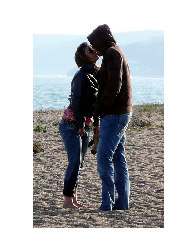

man is climbing into the beach


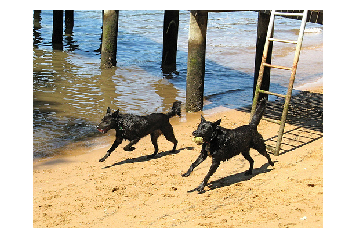

two black dogs are playing on the sand


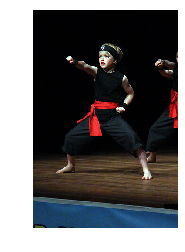

man wearing blue pants is doing on the air


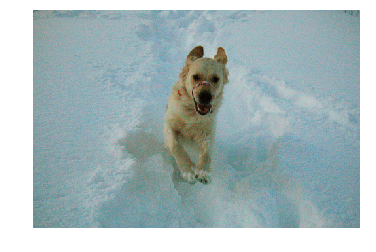

dog in the snow


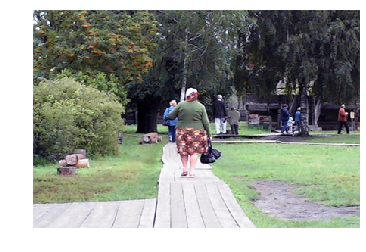

the man is standing on the cement


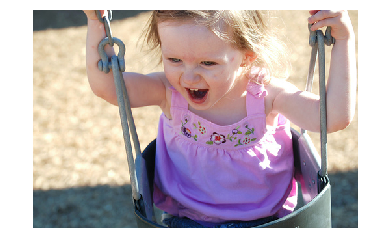

young girl is smiling on the pool


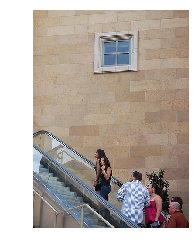

an dancer dancer with blue snowsuit


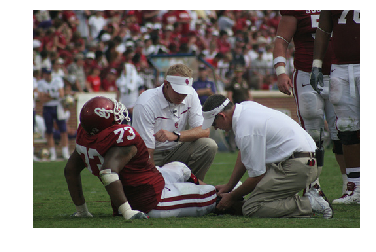

football player is holding his hands while his hands


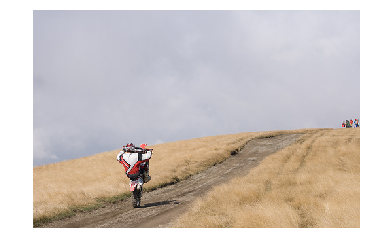

person is riding on snowy


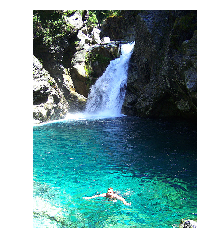

person swims into water


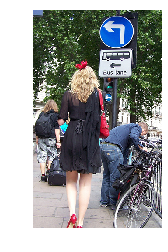

man wearing blue shoes and grey jeans and grey jeans and grey jeans and grey jeans and grey jeans and grey jeans and grey jeans and grey jeans and


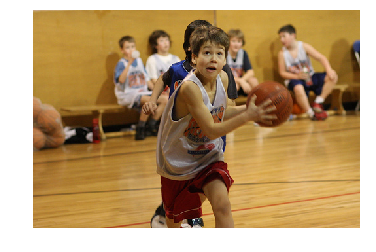

boy is playing basketball


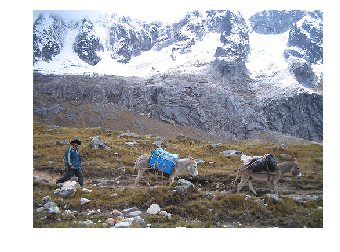

man is climbing on the peak


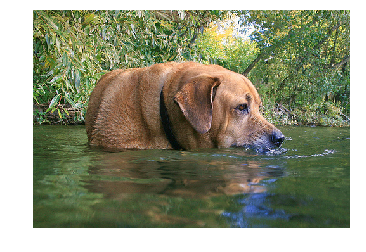

dog is walking through river


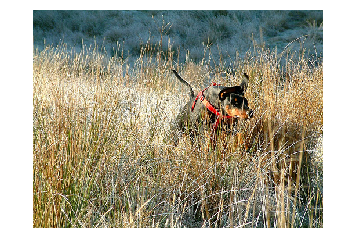

two dogs are running through the water


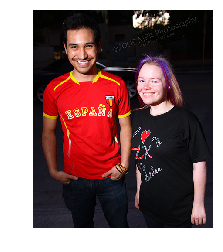

girl wearing red shirt is dancing


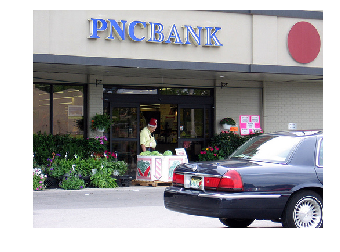

man is looking in front of street


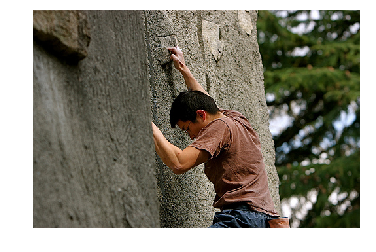

man scales climbing rock wall


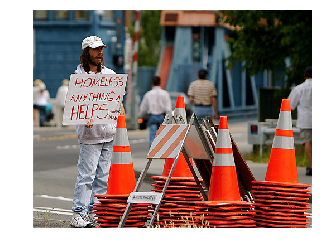

homeless in red vests and blue jacket and blue pants and blue pants and blue pants and walking down the city


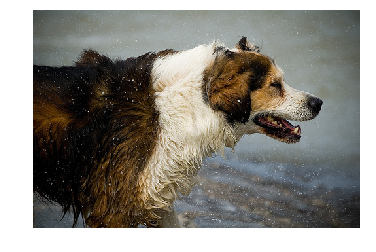

dog is walking through the water


In [166]:
for i in range(20):
    rn =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(images+img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)